In [ ]:
# !pip install gcpds
!pip install -U git+https://github.com/UN-GCPDS/python-gcpds.filters.git
!pip install -U git+https://github.com/UN-GCPDS/python-gcpds.utils.git
# FILEID = "121RAmnPo8lMxvEywEkT2wyFJNTaticlD" 
# !wget --load-cookies /tmp/cookies.txt "https://docs.google.com/uc?export=download&confirm=$(wget --quiet --save-cookies /tmp/cookies.txt --keep-session-cookies --no-check-certificate 'https://docs.google.com/uc?export=download&id='$FILEID -O- | sed -rn 's/.*confirm=([0-9A-Za-z_]+).*/\1\n/p')&id="$FILEID -O EEGFeatExtraction.py && rm -rf /tmp/cookies.txt !pip install -U git+https://github.com/UN-GCPDS/python-gcpds.filters.git 
!pip install mne

  Cloning https://github.com/UN-GCPDS/python-gcpds.filters.git to /tmp/pip-req-build-jvnh3teh
  Running command git clone -q https://github.com/UN-GCPDS/python-gcpds.filters.git /tmp/pip-req-build-jvnh3teh
  Cloning https://github.com/UN-GCPDS/python-gcpds.utils.git to /tmp/pip-req-build-botu4pzb
  Running command git clone -q https://github.com/UN-GCPDS/python-gcpds.utils.git /tmp/pip-req-build-botu4pzb


In [ ]:
# Libreria
from gcpds.filters.spatial import small_laplacian
from gcpds.utils import loaddb
import mne
from mne.preprocessing import ICA
from google.colab import drive
import requests
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
import seaborn as sn
import pickle
from ipywidgets import interact_manual
from ipywidgets import interact
# from MIfunctions import *
# from CKA_keras import *
from sklearn.pipeline import Pipeline
from sklearn.model_selection import StratifiedShuffleSplit, GridSearchCV
from sklearn.metrics import cohen_kappa_score
from sklearn.metrics import make_scorer
from sklearn.preprocessing import StandardScaler, MinMaxScaler
from sklearn.discriminant_analysis import LinearDiscriminantAnalysis as LDA
from time import time
import os
import mne
import numpy as np
from numpy import angle, sin, cos, sqrt
from scipy.io import loadmat
# from mat73 import loadmat
import scipy as sp
from scipy.io import savemat
from scipy.signal import butter, lfilter, welch, hanning, filtfilt, hilbert
import matplotlib.pyplot as plt
from gcpds.utils import loaddb
from gcpds.utils.visualizations import plot_eeg, plot_topoplot

In [ ]:
from scipy.stats import pearsonr

def ICA_EEG2(X, info, EEG_channels):
  # X_= X[:len(EEG_channels),:]
  X_ = X.get_data()[:,:len(EEG_channels),:]
  EEG_ICA = np.zeros(X_.shape)
  signals = X #mne.io.RawArray(X, info)
  filt_signals = signals.copy()
  ica = mne.preprocessing.ICA(n_components=len(EEG_channels),random_state=97)
  ica.fit(filt_signals)
  # eog_indices = []
  # eog_scores = []
  # for eog_ch in EOG_channels:
  #   eog_indices_aux, eog_scores_aux = ica.find_bads_eog(filt_signals, ch_name=eog_ch, threshold=3.0, verbose=False)
  #   eog_scores.append(eog_scores_aux)
  #   if len(eog_indices_aux)>0:
  #       for IC in eog_indices_aux:
  #         if IC not in eog_indices:
  #           eog_indices.append(IC)
  # ica.exclude = eog_indices
  corr_p = []
  vals = ica.get_sources(signals).get_data()
  for comp in range(vals.shape[1]):
    corr_tr = []
    for tr in range(X_.shape[0]):      
      if abs(pearsonr(vals[tr,comp,:],signals.get_data()[tr,0,:])[0]) > 0.6:
        corr_tr.append(comp)
      if abs(pearsonr(vals[tr,comp,:],signals.get_data()[tr,1,:])[0]) > 0.6:
        corr_tr.append(comp)
    if len(corr_tr)>0:
      corr_p.append(np.asarray(corr_tr))
  ica.exclude= list(np.unique(np.concatenate(corr_p)))
  reconst_raw = signals.copy()
  ica.apply(reconst_raw)
  # ._data[0:len(EEG_channels),:]
  # return reconst_raw, eog_indices, np.round(np.array(eog_scores),4), ica    
  return reconst_raw,corr_p,ica
  # return corr_p

sujeto:  1


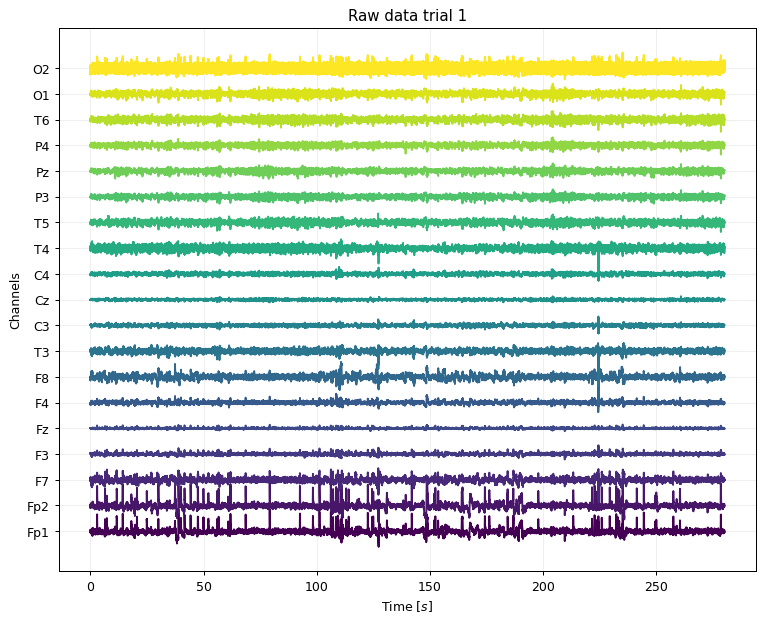

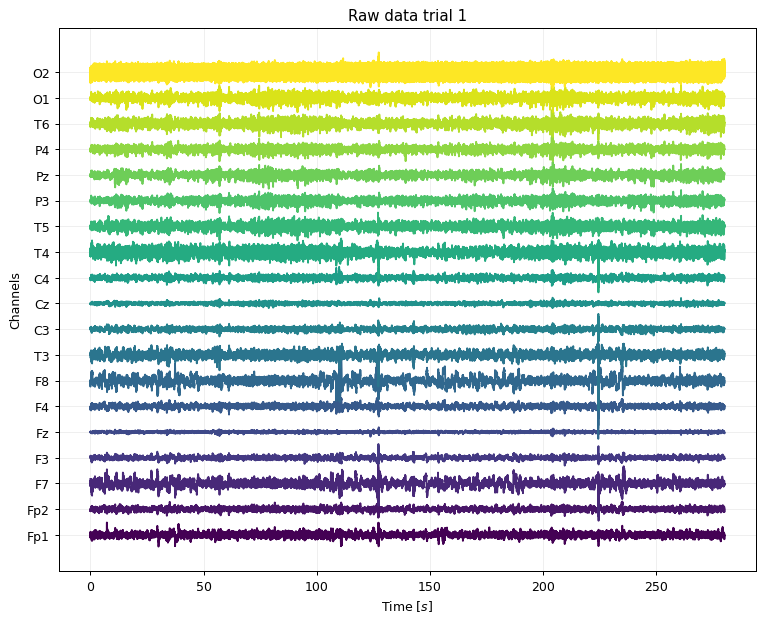

sujeto:  17


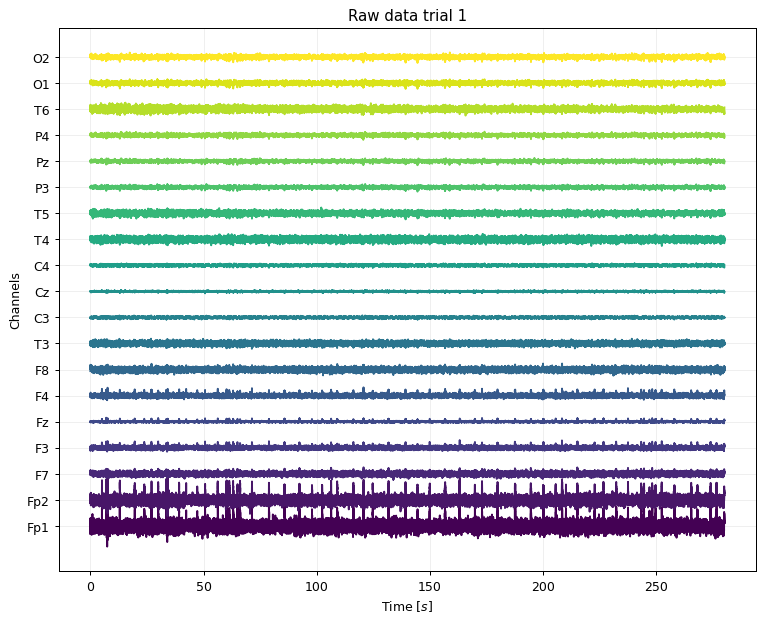

/usr/local/lib/python3.7/dist-packages/sklearn/decomposition/_fastica.py:119: ConvergenceWarning: FastICA did not converge. Consider increasing tolerance or the maximum number of iterations.
  ConvergenceWarning)


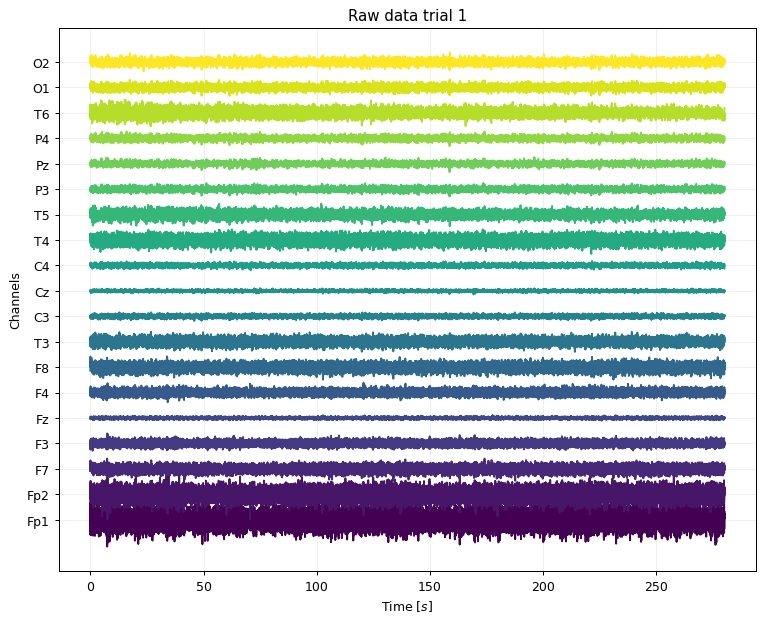

In [ ]:
## resting data
Subjects = list(np.arange(1,2))
Subjects2= [1,17]
channels = ['Fp1','Fp2','F7','F3','Fz','F4','F8','T3','C3','Cz','C4','T4',
            'T5','P3','Pz','P4','T6','O1','O2']
n_channels = len(channels)
sampling_freq  = 1000         # Frecuencia de muestreo de la base de datos.

load_path = '/content/drive/Shareddrives/GCPDS/databases/Auditory_processing/'
ch_names = channels
y = list()
method = 'fastica'
data_ref = list()
data_ref_raw=list()
for s in Subjects2:
  S_ERP = loadmat(load_path + f"P"+str(s)+"_BCMI_frontHN_2017.mat")
  print('sujeto: ', s)
  data = S_ERP['base']
  data = np.transpose(data, (1,0)) # transponer en canales x tiempo
  data = data[:n_channels,10*sampling_freq:-10*sampling_freq]
  data_target = np.zeros((1,data.shape[0],data.shape[1]))
  data_target[0,:,:] = data
  
  EEG_channels = channels
  # structure
  ch_types = ['eeg']*n_channels
  info = mne.create_info(ch_names, ch_types=ch_types, sfreq=sampling_freq)
  info.set_montage('standard_1005')
  raw = mne.EpochsArray(data_target, info)

  # filtro la señal.
  raw.filter(0.5,50)
  plt.figure(figsize=(10, 8), dpi=90)
  plt.title('Raw data trial 1')
  plot_eeg(raw.get_data()[0,:,:], EEG_channels, sampling_freq)
  plt.show()
  # Repairing artifacts with ICA
  # X_ica, ind, scores, ica = ICA_EEG(raw, info, EOG_channels, EEG_channels)
  
  X_ica,corr_p,ica_ = ICA_EEG2(raw, info, EEG_channels)
  # X_ica = ICA_EEG2(raw, info, EEG_channels)
  # # 
  # EEG_channels = channels[:-3]
  # ch_types     = ['eeg']*len(EEG_channels)
  # ch_names_ = ch_names[:-3]
  # info = mne.create_info(ch_names_, ch_types=ch_types, sfreq=sampling_freq)
  # info.set_montage('standard_1005')
  # #
  # rawt = mne.EpochsArray(raw.get_data()[:,:-3,:], info)
  # raw_.append(rawt)
  # #
  # xica = mne.EpochsArray(X_ica.get_data()[:,:-3,:], info)
  # X_ica_.append(xica)
  # # X_ica_o.append(mne.EpochsArray(X_ica.get_data()[:,-3:,:], info))

  # EOG_trials = raw.get_data()[:,-3:,:]
  # plt.figure(figsize=(5, 4), dpi=90)
  # plt.title('EOG data trial '+str(50))
  # plot_eeg(EOG_trials[50], EOG_channels, sampling_freq)
  # plt.show()
  # # raw_o.append(mne.EpochsArray(raw.get_data()[:,:-3,:], info))
  # # ica.plot_sources(raw, show_scrollbars=False)
  # # ica = ICA(n_components=19, method=method,max_iter='auto', random_state=0)
  # # ica.fit(raw,)
  # # ica.exclude = [11,16,18]         # indices chosen based on various plots above sujeto 2
  # # ica.exclude = [19] #[5,6,13,16]  # indices chosen based on various plots above sujeto 7
  # # # ica.plot_components()
  # # # ica.plot_sources(raw, show_scrollbars=False,)
  # # ica.apply(raw)
  # # ica.plot_sources(mne.io.RawArray(Xraw[50], info))
  # raw.filter(0.5,50)
  plt.figure(figsize=(10, 8), dpi=90)
  plt.title('Raw data trial 1')
  plot_eeg(X_ica.get_data()[0,:,:], EEG_channels, sampling_freq)
  plt.show()

  # ica.plot_sources(mne.io.RawArray(rawt.get_data()[50], info))

  # # CAR common average reference
  # # rereferenced_raw, ref_data = mne.set_eeg_reference(X_ica, ref_channels='average',projection=True,verbose=0)
  # # data_ref.append(rereferenced_raw.get_data())
  data_ref.append(X_ica.get_data())

  # # rereferenced_raw, ref_data = mne.set_eeg_reference(raw, ref_channels='average',projection=True,verbose=0)
  # # data_ref_raw.append(rereferenced_raw.get_data())
  data_ref_raw.append(raw.get_data())

  # # filter small laplacian 
  # # lab = small_laplacian(data_target,ch_names,'standard_1005')
  # # data_ref.append(lab)

In [ ]:
corr_p

[array([0, 0])]

In [ ]:
import time
import vq_function as vq
def fun_entropy(data):
  tau = 5
  entropy_ch = list()
  for ch in range(data.shape[0]):
    signal = np.squeeze(data[ch,:]).reshape(1,-1)
    r = 0.2*np.std(signal)
    E = vq.bayes_entropy2(signal,r,tau)
    entropy_ch.append(E)
  return np.asarray(entropy_ch)

In [ ]:
len(data_ref_raw)

2

In [ ]:
import multiprocessing
pool = multiprocessing.Pool(processes=multiprocessing.cpu_count())
# tau = 3 # 2,3,4
window  = 1*sampling_freq # 1,2 segundos
step    = window*0.1 # 90%
windows = list(np.arange(0,data_ref_raw[0].shape[2]-window,step))
# datos = np.squeeze(ica.get_sources(raw,).get_data(['misc']*19))
entropy_raw = list()
for sub in [0,1]: #Subjects:
  entropy_tr  = list()
  for tr in range(data_ref_raw[sub].shape[0]):
    # start_time = time.time()
    data = list()
    for time_ in range(len(windows)):
      signal = np.squeeze(data_ref_raw[sub][tr,:,int(windows[time_]):int(windows[time_]+window)])
      # signal = np.squeeze(datos[:,int(windows[time_]):int(windows[time_]+window)])
      data.append(signal)
    entropy_t = pool.map(fun_entropy, data)
    entropy_tr.append(np.asarray(entropy_t))
  entropy_sub = (np.asarray(entropy_tr))
  entropy_raw.append(np.asarray(entropy_sub))

In [ ]:
import multiprocessing
pool = multiprocessing.Pool(processes=multiprocessing.cpu_count())

# tau = 3 # 2,3,4
window  = 1*sampling_freq # 1,2 segundos
step    = window*0.1 # 90%
windows = list(np.arange(0,data_ref[0].shape[2]-window,step))
# datos = np.squeeze(ica.get_sources(raw,).get_data(['misc']*19))

entropy_8 = list()
for sub in [0,1]:#Subjects:
  entropy_tr = list()
  for tr in range(data_ref[sub].shape[0]):
    # start_time = time.time()
    data = list()
    for time_ in range(len(windows)):
      signal = np.squeeze(data_ref[sub][tr,:,int(windows[time_]):int(windows[time_]+window)])
      # signal = np.squeeze(datos[:,int(windows[time_]):int(windows[time_]+window)])
      data.append(signal)
    entropy_t = pool.map(fun_entropy, data)
    entropy_tr.append(np.asarray(entropy_t))
  entropy_sub = (np.asarray(entropy_tr))
  entropy_8.append(np.asarray(entropy_sub))

In [ ]:
from scipy.stats import pearsonr
# chans = [0,19]
corr_sub = []
for s in range(2):
  corr_tr = []
  for tr in range(data_ref[sub].shape[0]):
    corr_ch = []
    for ch in range(data_ref[sub].shape[1]):
      prod_r = abs(pearsonr(np.squeeze(data_ref_raw[s][tr,ch,:]),(np.squeeze(data_ref[s][tr,ch,:])))[0])
      prod = abs(pearsonr(np.squeeze(entropy_raw[s][tr,:,ch]),(np.squeeze(entropy_8[s][tr,:,ch])))[0])
      corr_ch.append([prod_r,prod])
    corr_tr.append(np.asarray(corr_ch))
  corr_sub.append(np.asarray(corr_tr))

In [ ]:
ydata[1]

array([0.72147611, 0.67358504, 0.92557026, 0.79509581, 0.55403547,
       0.81773474, 0.96631226, 0.96914705, 0.95756662, 0.85985554,
       0.95384565, 0.97327096, 0.93618525, 0.8904974 , 0.89329328,
       0.88907089, 0.94880674, 0.87688139, 0.87843379])

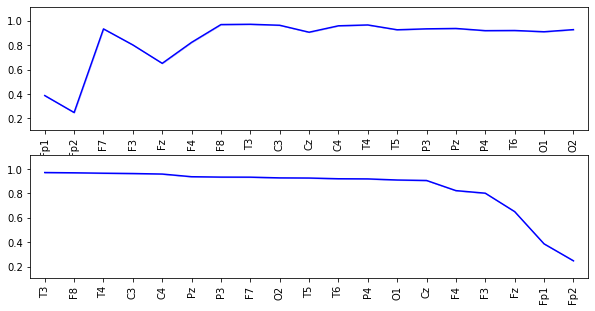

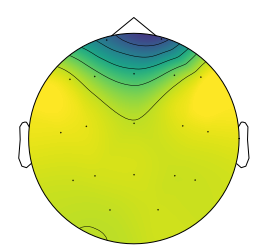

In [ ]:
import matplotlib
# Visualize the result
ydata = []
ydata_= []
for s in range(2):
  ydata.append(np.mean(corr_sub[s][:,:,0],axis=0))
  ydata_.append(np.std(corr_sub[s][:,:,0],axis=0))
xdata = list(np.arange(1,20))

s = 0
xfit = xdata
yfit = ydata[s]
yfit_ord=np.sort(yfit)[::-1]
ranked = np.argsort(yfit)[::-1]
dyfit= ydata_[s]
dyfit_ord = dyfit[ranked]
plt.figure(figsize=(10,5))
# plt.plot(xdata, ydata[0], 'ob')
plt.subplot(2,1,1)
plt.plot(xfit, yfit, '-', color='b')
plt.fill_between(xfit, yfit - dyfit, yfit + dyfit,
                 color='b', alpha=0.2)
plt.xticks(xdata, ch_names, rotation ='vertical')
# s = 1
# xfit = xdata
# yfit = ydata[s]
# yfit_ord=np.sort(yfit)[::-1]
# ranked = np.argsort(yfit)[::-1]
# dyfit= ydata_[s]
# dyfit_ord = dyfit[ranked]
# # plt.plot(xdata, ydata[0], 'ob')
# plt.plot(xfit, yfit, '-', color='r')
# plt.fill_between(xfit, yfit - dyfit, yfit + dyfit,
#                  color='r', alpha=0.2)
# plt.xticks(xdata, ch_names_, rotation ='vertical')
plt.xlim(0.5, 19.5)
plt.margins(0.2)


plt.subplot(2,1,2)
s = 0
xfit = xdata
yfit = ydata[s]
yfit_ord=np.sort(yfit)[::-1]
ranked = np.argsort(yfit)[::-1]
dyfit= ydata_[s]
dyfit_ord = dyfit[ranked]
plt.plot(xfit, yfit_ord, '-', color='b')
plt.fill_between(xfit, yfit_ord - dyfit_ord, yfit_ord + dyfit_ord,
                 color='b', alpha=0.2)

# s = 1
# xfit = xdata
# yfit = ydata[s]
# yfit_ord=np.sort(yfit)[::-1]
# dyfit= ydata_[s]
# dyfit_ord = dyfit[ranked]
# plt.plot(xfit, yfit_ord, '-', color='r')
# plt.fill_between(xfit, yfit_ord - dyfit_ord, yfit_ord + dyfit_ord,
#                  color='r', alpha=0.2)


plt.xlim(0.5, 19.5)
plt.margins(0.2)
ch_names_2 = np.asarray(ch_names)[ranked]
plt.xticks(xdata, ch_names_2, rotation ='vertical')
# plt.xticks(xdata, ch_names[:-3], rotation ='vertical')

plt.show()
mne.viz.plot_topomap(yfit,info,sensors=True,cmap='viridis',vmin=0,vmax=1)
plt.show()

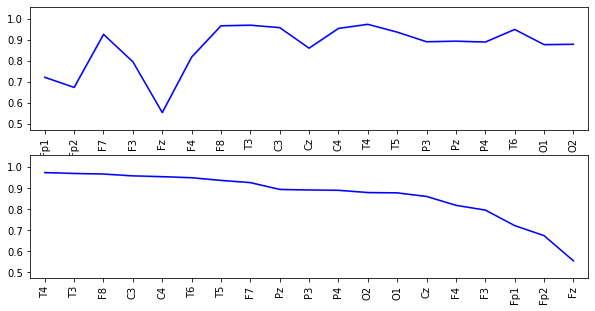

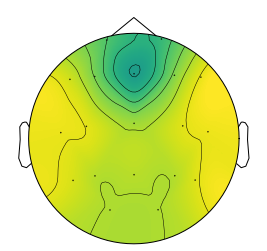

In [ ]:
import matplotlib
# Visualize the result
ydata = []
ydata_= []
for s in range(2):
  ydata.append(np.mean(corr_sub[s][:,:,0],axis=0))
  ydata_.append(np.std(corr_sub[s][:,:,0],axis=0))
xdata = list(np.arange(1,20))

s = 1
xfit = xdata
yfit = ydata[s]
yfit_ord=np.sort(yfit)[::-1]
ranked = np.argsort(yfit)[::-1]
dyfit= ydata_[s]
dyfit_ord = dyfit[ranked]
plt.figure(figsize=(10,5))
# plt.plot(xdata, ydata[0], 'ob')
plt.subplot(2,1,1)
plt.plot(xfit, yfit, '-', color='b')
plt.fill_between(xfit, yfit - dyfit, yfit + dyfit,
                 color='b', alpha=0.2)
plt.xticks(xdata, ch_names, rotation ='vertical')
# s = 1
# xfit = xdata
# yfit = ydata[s]
# yfit_ord=np.sort(yfit)[::-1]
# ranked = np.argsort(yfit)[::-1]
# dyfit= ydata_[s]
# dyfit_ord = dyfit[ranked]
# # plt.plot(xdata, ydata[0], 'ob')
# plt.plot(xfit, yfit, '-', color='r')
# plt.fill_between(xfit, yfit - dyfit, yfit + dyfit,
#                  color='r', alpha=0.2)
# plt.xticks(xdata, ch_names_, rotation ='vertical')
plt.xlim(0.5, 19.5)
plt.margins(0.2)


plt.subplot(2,1,2)
s = 1
xfit = xdata
yfit = ydata[s]
yfit_ord=np.sort(yfit)[::-1]
ranked = np.argsort(yfit)[::-1]
dyfit= ydata_[s]
dyfit_ord = dyfit[ranked]
plt.plot(xfit, yfit_ord, '-', color='b')
plt.fill_between(xfit, yfit_ord - dyfit_ord, yfit_ord + dyfit_ord,
                 color='b', alpha=0.2)

# s = 1
# xfit = xdata
# yfit = ydata[s]
# yfit_ord=np.sort(yfit)[::-1]
# dyfit= ydata_[s]
# dyfit_ord = dyfit[ranked]
# plt.plot(xfit, yfit_ord, '-', color='r')
# plt.fill_between(xfit, yfit_ord - dyfit_ord, yfit_ord + dyfit_ord,
#                  color='r', alpha=0.2)


plt.xlim(0.5, 19.5)
plt.margins(0.2)
ch_names_2 = np.asarray(ch_names)[ranked]
plt.xticks(xdata, ch_names_2, rotation ='vertical')
# plt.xticks(xdata, ch_names[:-3], rotation ='vertical')

plt.show()
mne.viz.plot_topomap(yfit,info,sensors=True,cmap='viridis',vmin=0,vmax=1)
plt.show()